<a href="https://colab.research.google.com/github/AndreiLesi/Data-Engineering/blob/master/churnAnalysis%20-%20MLvsDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Churn Analysis - using sklearn**

### **Context**

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

### **Content**

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents



## Load Data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns      
sns.set(style="darkgrid")
import matplotlib.ticker as mtick # For specifying the axes tick format 
from sklearn import metrics
import xgboost
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, \
                                    cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, \
                            plot_confusion_matrix , ConfusionMatrixDisplay
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

In [ ]:
# Goal: Predict if a customer will churn/cancel subscription or not based on a 
# number of parameters
# Read Dataset
url = "https://raw.githubusercontent.com/treselle-systems/customer_churn_"\
      "analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(url, na_values=" ")

# Preview dataset
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Checking the data types of all the columns
print(df.dtypes, "\n\n")

# Checking for missing values and remove rows
print(df.isnull().sum(), "\n\n")
df.dropna(inplace = True)

# Remove customerID from Dataset
df = df.drop("customerID", axis=1)


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object 


customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
Paym

# Data Exploration

## Target Value

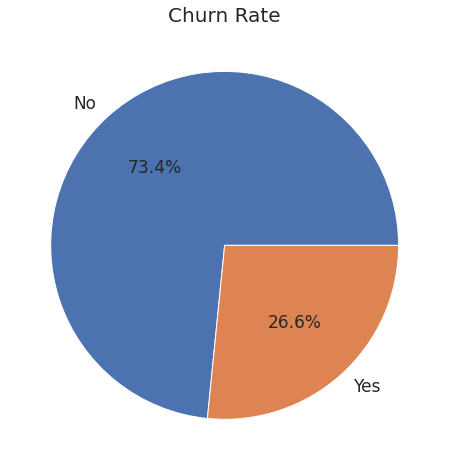

In [ ]:
plt.figure()
df["Churn"].value_counts().plot.pie(figsize=(8, 8), autopct='%1.1f%%', fontsize=17)
plt.ylabel("")
plt.title("Churn Rate", fontsize=20)
plt.show()

## Demographics

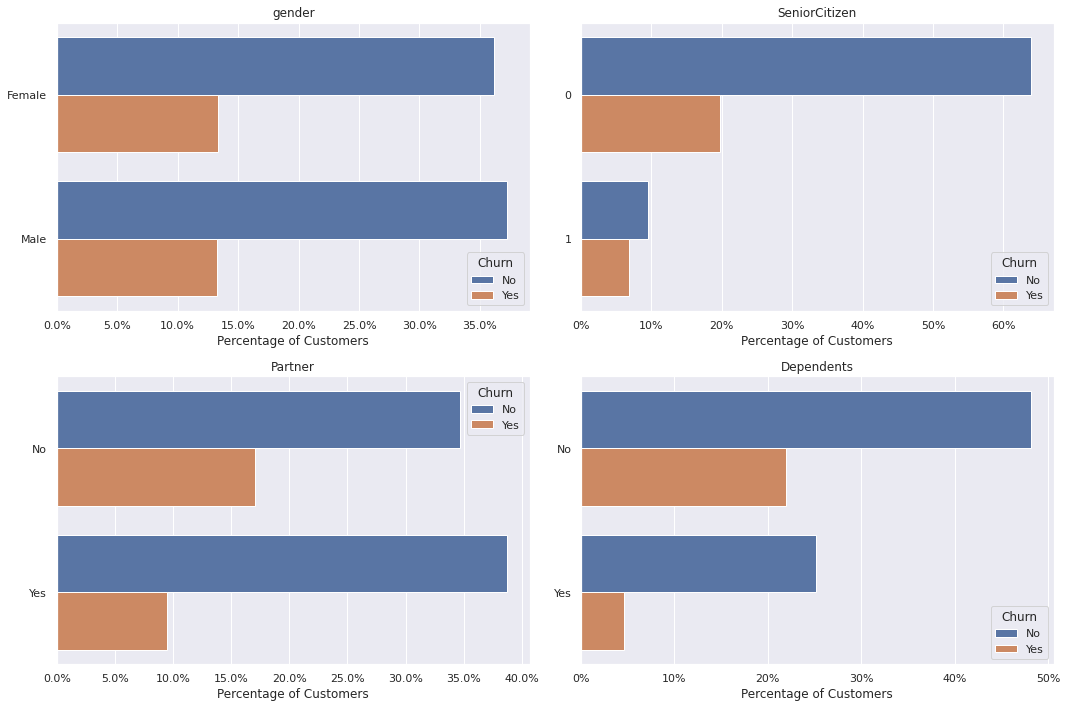

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
axlist = [val for sublist in ax for val in sublist]
cols = ["gender", "SeniorCitizen", 'Partner', 'Dependents']
axis_name = "Percentage of Customers"

for i in range(len(cols)):
  g = df.groupby(cols[i])["Churn"].value_counts().to_frame()
  g = g.rename({"Churn": axis_name}, axis=1).reset_index()
  g[axis_name] = g[axis_name]/len(df) * 100
  ax = sns.barplot(y=cols[i], x= axis_name, hue='Churn', orient='h', data=g, 
                   ax=axlist[i])
  ax.xaxis.set_major_formatter(mtick.PercentFormatter())
  ax.set_title(ax.yaxis.get_label_text())
  ax.set_ylabel("")
  # for p in ax.patches:
  #   width, height = p.get_width(), p.get_height()
  #   x, y = p.get_xy() 
  #   ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
  #               color = 'white',
  #              weight = 'bold',
  #              size = 14)

fig.tight_layout()

## Contract infomration

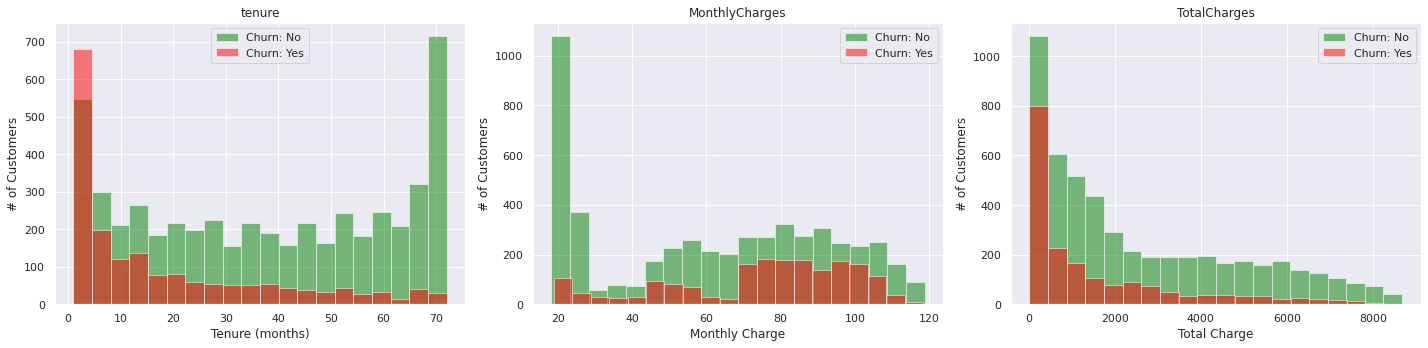

In [ ]:
# Analyze numerical data 
numerical_features = ['tenure',"MonthlyCharges", "TotalCharges"]
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
df[df.Churn == 'No'][numerical_features].hist(bins=20, color="green", alpha=0.5,
                                              ax=ax, label="Churn: No")
df[df.Churn == 'Yes'][numerical_features].hist(bins=20, color="red", alpha=0.5, 
                                               ax=ax, label="Churn: Yes")

xlabels = ["Tenure (months)", "Monthly Charge", "Total Charge"]
for i in range(3):
  ax[i].set_ylabel("# of Customers")
  ax[i].set_xlabel(xlabels[i])
  ax[i].legend()

fig.tight_layout()

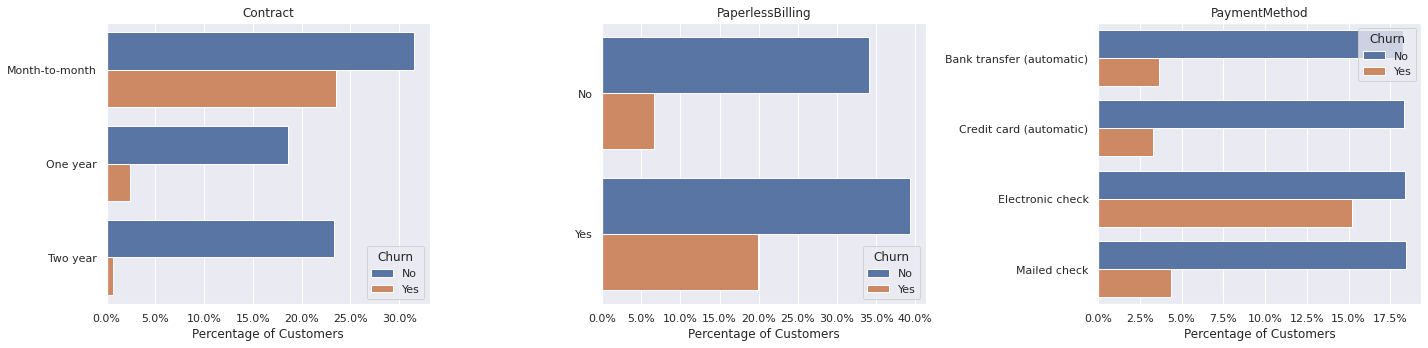

In [ ]:
fig, axlist = plt.subplots(1,3, figsize=(20,5))
cols = ['Contract', 'PaperlessBilling', 'PaymentMethod']
axis_name = "Percentage of Customers"

for i in range(len(cols)):
  g = df.groupby(cols[i])["Churn"].value_counts().to_frame()
  g = g.rename({"Churn": axis_name}, axis=1).reset_index()
  g[axis_name] = g[axis_name]/len(df) * 100
  ax = sns.barplot(y=cols[i], x=axis_name, hue='Churn', orient='h', data=g, ax=axlist[i])
  ax.xaxis.set_major_formatter(mtick.PercentFormatter())
  ax.set_title(ax.yaxis.get_label_text())
  ax.set_ylabel("")
  # for p in ax.patches:
  #   width, height = p.get_width(), p.get_height()
  #   x, y = p.get_xy() 
  #   ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
  #               color = 'white',
  #              weight = 'bold',
  #              size = 14)

fig.tight_layout()

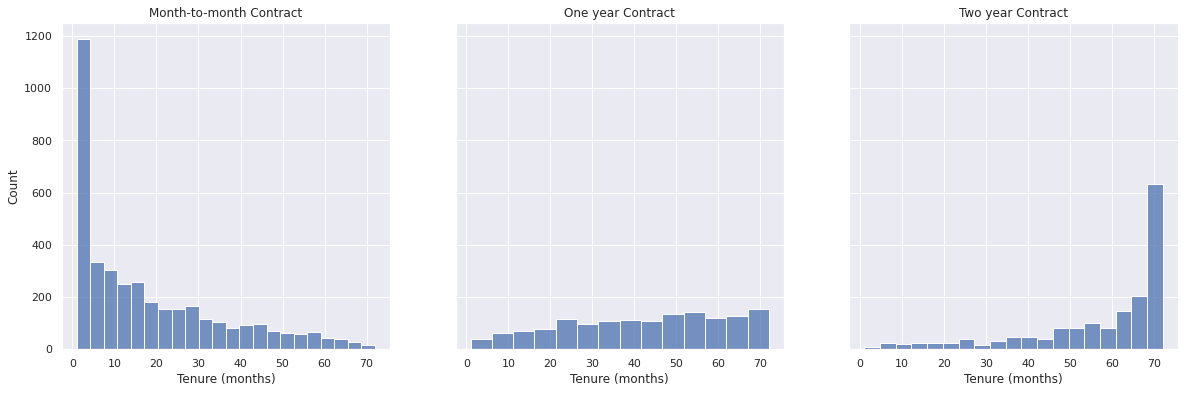

In [ ]:
fig, axlist = plt.subplots(1, 3, sharey = True, figsize = (20,6))
cols = ["Month-to-month", "One year", "Two year"]

for i,col in enumerate(cols):
  ax = sns.histplot(df[df['Contract']==col]['tenure'],
                    line_kws={'edgecolor':'black'},
                    ax=axlist[i])
  if i == 1: ax.set_ylabel('# of Customers')
  ax.set_xlabel('Tenure (months)')
  ax.set_title(f'{col} Contract')

## Services

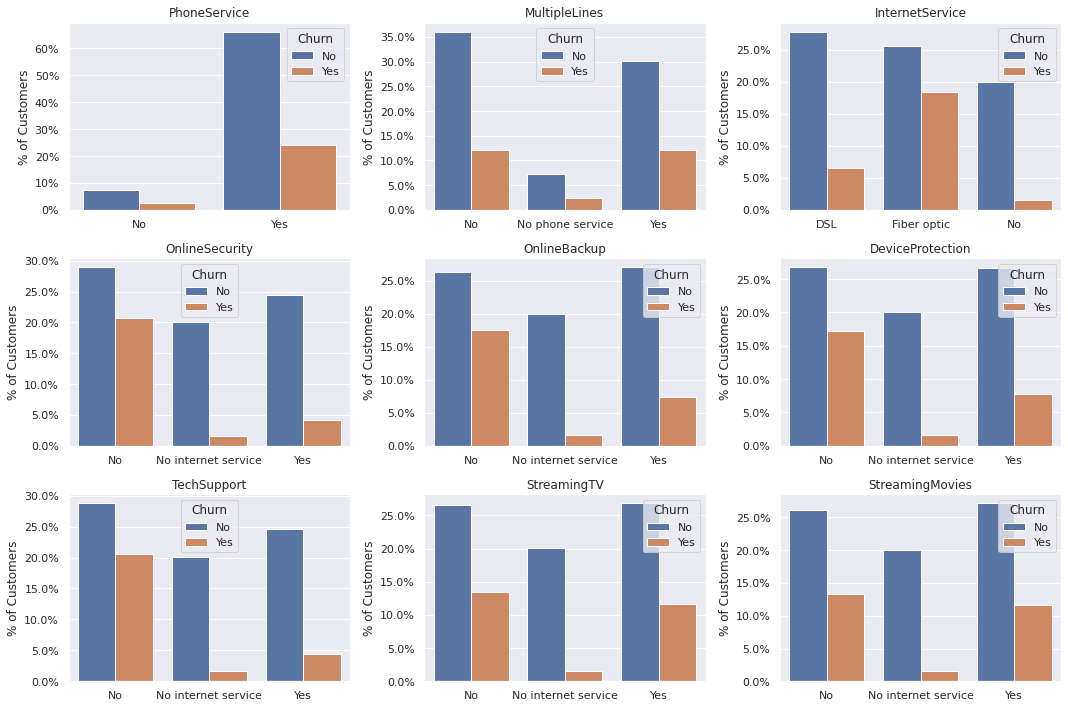

In [ ]:
# Analyze Categorical Data
catColumns = ['PhoneService', 'MultipleLines', 'InternetService',
              'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
              'TechSupport', 'StreamingTV', 'StreamingMovies']

fig, ax = plt.subplots(3,3, figsize=(15,10))
axlist = [val for sublist in ax for val in sublist]
axis_name = "% of Customers"

for i in range(len(catColumns)):
  df2= df.groupby(catColumns[i])["Churn"].value_counts().to_frame()
  df2 = df2.rename({"Churn": axis_name}, axis=1).reset_index()
  df2[axis_name] = df2[axis_name]/len(df) * 100
  ax = sns.barplot(x=catColumns[i], y=axis_name, hue='Churn', data=df2, 
                   ax=axlist[i])
  ax.yaxis.set_major_formatter(mtick.PercentFormatter())
  ax.set_title(ax.xaxis.get_label_text())
  ax.set_xlabel("")

fig.tight_layout()

# Data preprocessing and cleaning


In [ ]:
# Convert predictor variable in binary numeric variable
cleaned_df = df
cleaned_df["Churn"].replace(to_replace="Yes", value=1, inplace=True)
cleaned_df["Churn"].replace(to_replace="No", value=0, inplace=True)

# Convert all the non-numeric columns to numerical data types
cleaned_df = pd.get_dummies(cleaned_df)

# Split data 
X = cleaned_df.drop('Churn', axis = 1) 
y = cleaned_df['Churn']
features = X.columns.values

# Standardize Data
# X = pd.DataFrame(StandardScaler().fit_transform(X))
X = pd.DataFrame(MinMaxScaler(feature_range = (0,1)).fit_transform(X))
X.columns = features

# Split the data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=101) 
cleaned_df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


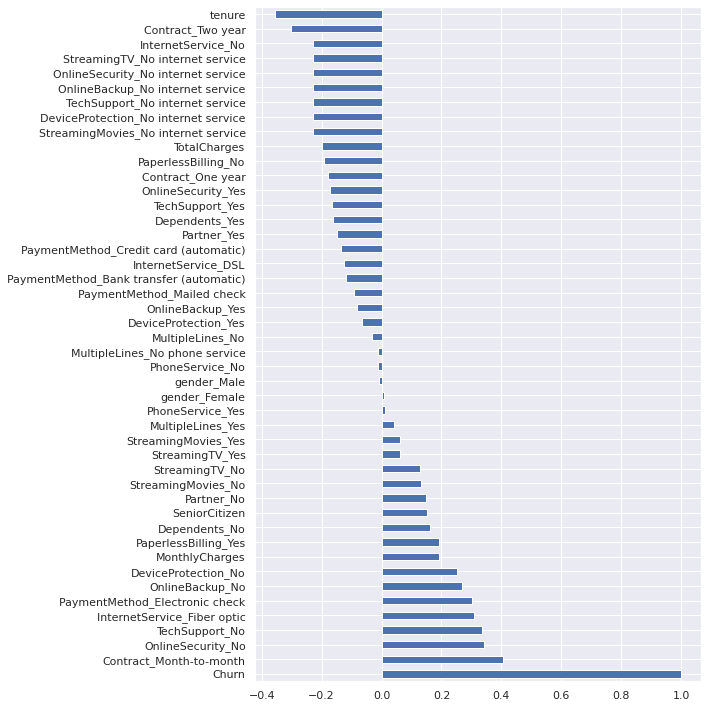

In [ ]:
#Get Correlation of "Churn" with other variables:
fig = plt.figure(figsize=(10,10))
cleaned_df.corr()['Churn'].sort_values(ascending = False).plot(kind='barh')
fig.tight_layout()

# Logistic Regression

In [ ]:
# Grid Search Parameters
params = {'penalty': ['l1', 'l2'],
          'C': np.logspace(-4, 4, 50), 
          'solver': ['liblinear', 'saga']}

# Train Random Forest Classifier using Randomized Grid Search
model_lr= LogisticRegression(max_iter=500) 
random_cv = RandomizedSearchCV(model_lr, param_distributions=params,n_iter=15, 
                               scoring="roc_auc", cv=5, n_jobs=-1, verbose=1)
random_cv.fit(X_train, y_train)
print(f"Best Score:{random_cv.best_score_} \n {random_cv.best_params_}")
model_lr = random_cv.best_estimator_.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    6.8s finished


Best Score:0.8490758353245556 
 {'solver': 'liblinear', 'penalty': 'l2', 'C': 109.85411419875572}


In [ ]:
# Make Predictions
prediction_test = model_lr.predict(X_test)

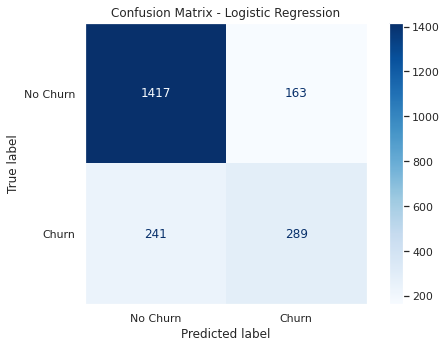



              precision    recall  f1-score   support

    No Churn       0.85      0.90      0.88      1580
       Churn       0.64      0.55      0.59       530

    accuracy                           0.81      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.80      0.81      0.80      2110



In [ ]:
sns.set(style="dark")

# Plot Confusion Matrix
fig, ax = plt.subplots(1,1, figsize=(7,5))
disp = plot_confusion_matrix(model_lr, X_test, y_test, values_format="d", ax=ax,
                            cmap="Blues", display_labels=["No Churn", "Churn"]) 
disp.ax_.set_title("Confusion Matrix - Logistic Regression")
fig.tight_layout()
plt.show()

# Compute Precision, Recall, Accuracy, F1-Score
repo = classification_report(y_test, prediction_test, 
                             target_names = ["No Churn", "Churn"])
print(f"\n\n{repo}")

0.8071090047393364


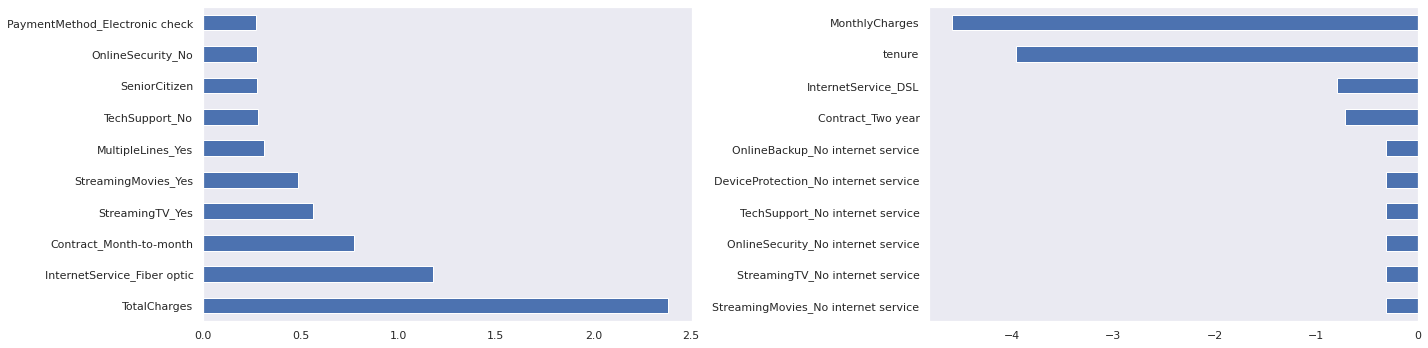

In [ ]:
# To get the weights of all the variables
weights = pd.Series(model_lr.coef_[0], index=X.columns.values)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
weights.sort_values(ascending = False)[:10].plot(kind='barh', ax=ax[0])
weights.sort_values(ascending = False)[-10:].plot(kind='barh', ax=ax[1])
fig.tight_layout()

# Random Forest Classifier

In [ ]:
# Grid Search Parameters
params = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, 
                                                       num = 10)],
          'max_features': ['auto', 'sqrt'],
          'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] +[None],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'bootstrap': [True, False]}

# Train Random Forest Classifier using Randomized Grid Search
model_rf= RandomForestClassifier(n_jobs=-1) 
random_cv = RandomizedSearchCV(model_rf, param_distributions=params,n_iter=30, 
                               scoring="roc_auc", cv=5, verbose=1)
random_cv.fit(X_train, y_train)
print(f"Best Score:{random_cv.best_score_} \n {random_cv.best_params_}")
model_rf = random_cv.best_estimator_.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 14.3min finished


Best Score:0.8511772249384292 
 {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


In [ ]:
params = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, 
                                                       num = 10)],
          'max_features': ['auto', 'sqrt'],
          'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] +[None],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'bootstrap': [True, False]}
params

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
# Make Prediction
prediction_test = model_rf.predict(X_test)

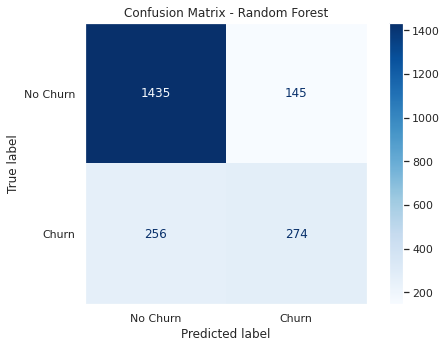



              precision    recall  f1-score   support

    No Churn       0.85      0.91      0.88      1580
       Churn       0.65      0.52      0.58       530

    accuracy                           0.81      2110
   macro avg       0.75      0.71      0.73      2110
weighted avg       0.80      0.81      0.80      2110



In [ ]:
# Compute Confusion matrix and classification metrics
fig, ax = plt.subplots(1,1, figsize=(7,5))
disp = plot_confusion_matrix(model_rf, X_test, y_test, values_format="d", ax=ax, 
                            cmap="Blues", display_labels=["No Churn", "Churn"]) 
disp.ax_.set_title("Confusion Matrix - Random Forest")
fig.tight_layout()
plt.show()

repo = classification_report(y_test, prediction_test, 
                             target_names = ["No Churn", "Churn"])
print(f"\n\n{repo}")

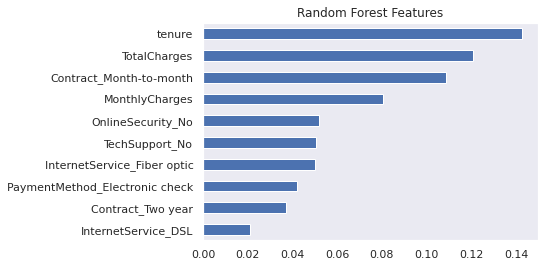

In [ ]:
# Extract Features
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
fig = plt.figure()
ax = weights.sort_values()[-10:].plot(kind = 'barh')
ax.set_title("Random Forest Features")
plt.show()

# Support Vector Machines

In [ ]:
# Grid Search Parameters
params = {
    "C": [0.1, 1, 2, 4, 6, 8, 10, 15, 25, 50, 100],
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear']
}
# Train Support Vector Machines using Randomized Grid Search
model_svm= SVC() 
random_cv = RandomizedSearchCV(model_svm, param_distributions=params,n_iter=50, 
                               scoring="roc_auc", cv=5, verbose=1, n_jobs=-1)
random_cv.fit(X_train, y_train)
print(f"Best Score:{random_cv.best_score_} \n {random_cv.best_params_}")
model_svm = random_cv.best_estimator_.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  5.2min finished


Best Score:0.8413640745406988 
 {'kernel': 'rbf', 'gamma': 0.001, 'C': 8}


In [ ]:
# Make Prediction
prediction_test = model_svm.predict(X_test)

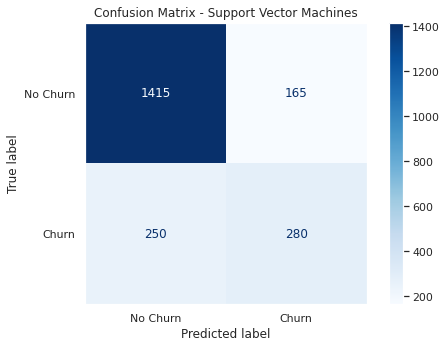



              precision    recall  f1-score   support

    No Churn       0.85      0.90      0.87      1580
       Churn       0.63      0.53      0.57       530

    accuracy                           0.80      2110
   macro avg       0.74      0.71      0.72      2110
weighted avg       0.79      0.80      0.80      2110



In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
disp = plot_confusion_matrix(model_svm, X_test, y_test, values_format="d",ax=ax,
                            cmap="Blues", display_labels=["No Churn", "Churn"]) 
disp.ax_.set_title("Confusion Matrix - Support Vector Machines")
fig.tight_layout()
plt.show()

repo = classification_report(y_test, prediction_test, target_names = 
                             ["No Churn", "Churn"])
print(f"\n\n{repo}")

In [ ]:
# Extract Features
importances = model_svm.coef_[0]
weights = pd.Series(importances, index=X.columns.values)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
weights.sort_values(ascending = False)[:8].plot(kind='barh', ax=ax[0])
weights.sort_values(ascending = False)[-8:].plot(kind='barh', ax=ax[1])
fig.tight_layout()

# XGBoost

In [ ]:
# Grid Search Parameters
params = {
    "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
}

# Train XGBoost using Randomized Grid Search
model_xg= xgboost.XGBClassifier()
random_cv = RandomizedSearchCV(model_xg, param_distributions=params,n_iter=50, 
                               scoring="roc_auc", cv=5, n_jobs=-1, verbose=1)
random_cv.fit(X_train, y_train)
model_xg = random_cv.best_estimator_.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.0min finished


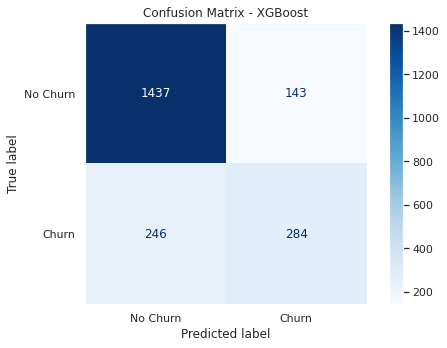



              precision    recall  f1-score   support

    No Churn       0.85      0.91      0.88      1580
       Churn       0.67      0.54      0.59       530

    accuracy                           0.82      2110
   macro avg       0.76      0.72      0.74      2110
weighted avg       0.81      0.82      0.81      2110



In [ ]:
# Make Prediction
prediction_test = model_xg.predict(X_test)

# Compute Confusion matrix and classification metrics
fig, ax = plt.subplots(1,1, figsize=(7,5))
disp = plot_confusion_matrix(model_xg, X_test, y_test, values_format="d", ax=ax,
                            cmap="Blues", display_labels=["No Churn", "Churn"]) 
disp.ax_.set_title("Confusion Matrix - XGBoost")
fig.tight_layout()
plt.show()

# Create Classification Report: Precision, Recall, Accuracy, F1-Score
repo = classification_report(y_test, prediction_test, 
                             target_names = ["No Churn", "Churn"])

# Repo as Table
#repo = classification_report(y_test, prediction_test, output_dict=True,
#                             target_names = ["No Churn", "Churn"])
#repo = pd.DataFrame(repo).transpose()

print(f"\n\n{repo}")

# Deep Learning Approach

In [ ]:
# Define Estimator Model for Randomized/GridSearchCV
def create_model(layers, learning_rate, dropout_rate):
  classifier = Sequential()
  
  # Add Hidden layers
  for i, nodes in enumerate(layers):
    if i == 0:
      classifier.add(Dense(nodes, activation='relu', input_dim=X_train.shape[1]))
      classifier.add(Dropout(dropout_rate))
    else: 
      classifier.add(Dense(nodes, activation='relu'))
      classifier.add(Dropout(dropout_rate))

  # Add Output Layers:
  classifier.add(Dense(1, activation = 'sigmoid'))

  # Optimizer
  optimizer = Adam(learning_rate=learning_rate)

  # Compiling the ANN
  classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return classifier

## Run Randomized Grid Search to find good initial estimations for the NN Parameters

In [ ]:
# Grid Parameters
model = KerasClassifier(build_fn=create_model, verbose=0)
layers = [(20, 15, 7), (40, 20), (45, 30, 15), (30, 20, 10, 5)]
batch_size = [10, 20, 40, 60]
epochs = [10, 15, 20, 25, 30]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
dropout_rate = [0.1, 0.2, 0.3]
param_grid = dict(layers=layers, batch_size=batch_size, epochs=epochs, 
                  learning_rate=learning_rate, dropout_rate=dropout_rate)

# Run Grid Search with DNN Regressor Architecture
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3,
                          return_train_score=True, n_iter=40, verbose=1)
grid_result = grid.fit(X_train, y_train, validation_split=0.3)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 19.0min finished


In [ ]:
# Analyze Parameter Grid Result:
params_df = pd.DataFrame(grid.cv_results_,
                       columns=['params','mean_train_score',
                                'mean_test_score'])
params_df.set_index('params', inplace=True)
display(params_df.sort_values(by=["mean_test_score"], ascending=False))

print("Best Estimator:", grid.best_estimator_,
     "Best Score:",     grid.best_score_,
     "Best Params:",    grid.best_params_, sep="\n")

,mean_train_score,mean_test_score
params,,
"{'learning_rate': 0.001, 'layers': (45, 30, 15), 'epochs': 25, 'dropout_rate': 0.1, 'batch_size': 60}",0.819179,0.796222
"{'learning_rate': 0.001, 'layers': (45, 30, 15), 'epochs': 25, 'dropout_rate': 0.2, 'batch_size': 10}",0.823954,0.794392
"{'learning_rate': 0.001, 'layers': (45, 30, 15), 'epochs': 15, 'dropout_rate': 0.2, 'batch_size': 10}",0.811053,0.793376
"{'learning_rate': 0.001, 'layers': (20, 15, 7), 'epochs': 15, 'dropout_rate': 0.2, 'batch_size': 40}",0.800488,0.792972
"{'learning_rate': 0.001, 'layers': (45, 30, 15), 'epochs': 15, 'dropout_rate': 0.3, 'batch_size': 40}",0.805770,0.792159
"{'learning_rate': 0.001, 'layers': (30, 20, 10, 5), 'epochs': 10, 'dropout_rate': 0.2, 'batch_size': 20}",0.799168,0.791345
"{'learning_rate': 0.01, 'layers': (45, 30, 15), 'epochs': 20, 'dropout_rate': 0.1, 'batch_size': 10}",0.814710,0.790940
"{'learning_rate': 0.001, 'layers': (40, 20), 'epochs': 10, 'dropout_rate': 0.1, 'batch_size': 60}",0.800996,0.790939
"{'learning_rate': 0.001, 'layers': (45, 30, 15), 'epochs': 15, 'dropout_rate': 0.1, 'batch_size': 10}",0.821617,0.789314


Best Estimator:
Best Score:
0.7962215542793274
Best Params:
{'learning_rate': 0.001, 'layers': (45, 30, 15), 'epochs': 25, 'dropout_rate': 0.1, 'batch_size': 60}


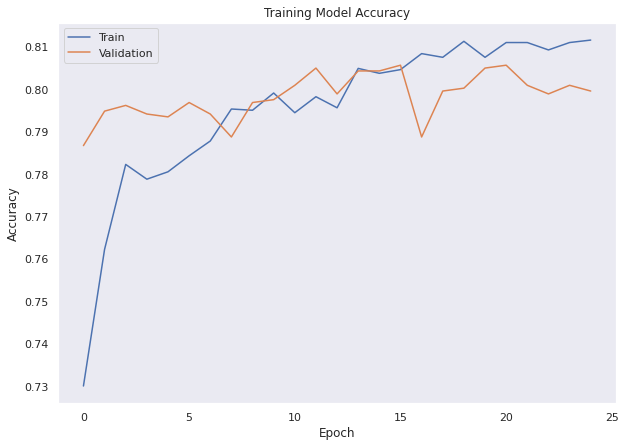

In [ ]:
# Check Training and Test Validation Accuracy for Overfitting
plt.figure(figsize=(10, 7))
plt.plot(grid.best_estimator_.model.history.history['accuracy'])
plt.plot(grid.best_estimator_.model.history.history['val_accuracy'])
plt.title('Training Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# Run Grid Search to optimized points around the best solutions provided found with Randomized Search

In [ ]:
# Grid Parameters
model = KerasClassifier(build_fn=create_model, verbose=0)
layers = [(45, 30, 15)]
batch_size = [20]
epochs = [10, 15]
learning_rate = [0.0001, 0.001, 0.01]
dropout_rate = [0.1, 0.2]
param_grid = dict(layers=layers, batch_size=batch_size, epochs=epochs, 
                  learning_rate=learning_rate, dropout_rate=dropout_rate)

# Grid Search with DNN Regressor Architecture
grid2 = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                          return_train_score=True, verbose=1)
grid_result2 = grid2.fit(X_train, y_train, validation_split=0.3)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  7.5min finished


In [ ]:
# Analyze Parameter Grid Result:
params_df2 = pd.DataFrame(grid2.cv_results_,
                       columns=['params','mean_train_score',
                                'mean_test_score'])
params_df2.set_index('params', inplace=True)
display(params_df2.sort_values(by=["mean_test_score"], ascending=False))

,mean_train_score,mean_test_score
params,,
"{'batch_size': 20, 'dropout_rate': 0.1, 'epochs': 10, 'layers': (45, 30, 15), 'learning_rate': 0.001}",0.805923,0.797439
"{'batch_size': 20, 'dropout_rate': 0.1, 'epochs': 15, 'layers': (45, 30, 15), 'learning_rate': 0.001}",0.817046,0.795816
"{'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 10, 'layers': (45, 30, 15), 'learning_rate': 0.01}",0.799624,0.793378
"{'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 10, 'layers': (45, 30, 15), 'learning_rate': 0.001}",0.804855,0.793376
"{'batch_size': 20, 'dropout_rate': 0.1, 'epochs': 15, 'layers': (45, 30, 15), 'learning_rate': 0.01}",0.805771,0.791547
"{'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 15, 'layers': (45, 30, 15), 'learning_rate': 0.0001}",0.789415,0.790737
"{'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 15, 'layers': (45, 30, 15), 'learning_rate': 0.01}",0.801757,0.790535
"{'batch_size': 20, 'dropout_rate': 0.1, 'epochs': 10, 'layers': (45, 30, 15), 'learning_rate': 0.01}",0.800843,0.790534
"{'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 15, 'layers': (45, 30, 15), 'learning_rate': 0.001}",0.808411,0.790532


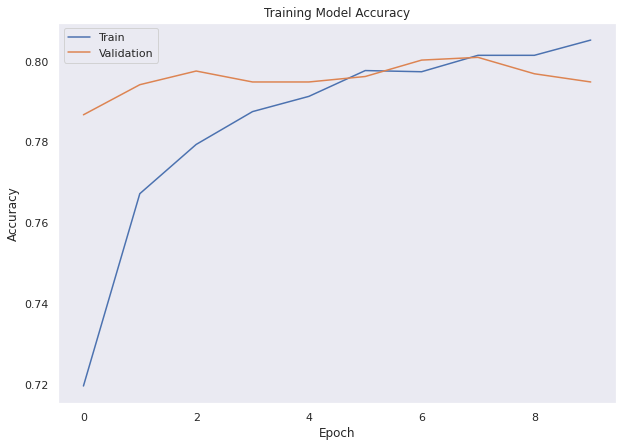

In [ ]:
# Check Training and Test Validation Accuracy for Overfitting
plt.figure(figsize=(10, 7))
plt.plot(grid2.best_estimator_.model.history.history['accuracy'])
plt.plot(grid2.best_estimator_.model.history.history['val_accuracy'])
plt.title('Training Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

## Compute Confusion Matrix and Classification Report using the test dataset

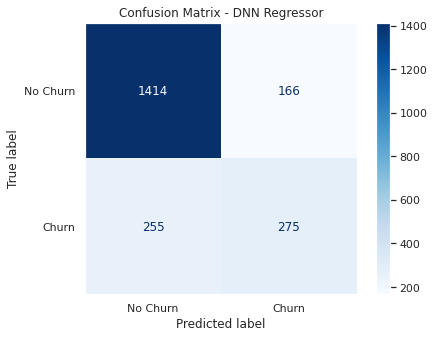



              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1580
       Churn       0.62      0.52      0.57       530

    accuracy                           0.80      2110
   macro avg       0.74      0.71      0.72      2110
weighted avg       0.79      0.80      0.79      2110



In [ ]:
# Get Classifier and make predictions
classifier = grid2.best_estimator_
prediction_test = classifier.predict(X_test)
prediction_test = (prediction_test > 0.5)

# Compute Confusion matrix and classification metrics
fig, ax = plt.subplots(1,1, figsize=(7,5))
cm = confusion_matrix(y_true=y_test, y_pred=prediction_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=["No Churn", "Churn"])
disp = disp.plot(cmap="Blues", values_format="d", ax=ax)
disp.ax_.set_title("Confusion Matrix - DNN Regressor")
plt.show()

# Create Classification Report: Precision, Recall, Accuracy, F1-Score
repo = classification_report(y_test, prediction_test, 
                             target_names = ["No Churn", "Churn"])
print(f"\n\n{repo}")